<h1>Предсказание массы рыбы</h1>

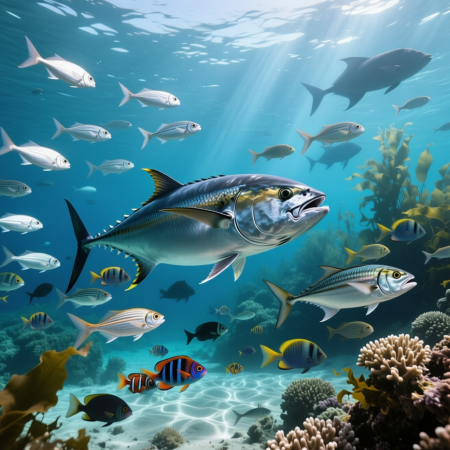

**Импорт библиотек и подгрузка данных:**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
plt.style.use('ggplot')

Всего датасет содержит 159 записей. Мы предварительно зарезервировали часть датасета для задания по преодолению бейслайна (baseline). В настоящем задании подразумевается работа с датасетом, содержащим 119 записей.

In [ ]:
data = pd.read_csv('fish_train.csv')

In [ ]:
data[:3]

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Roach,150.0,20.4,22.0,24.7,5.8045,3.7544
1,Perch,250.0,25.4,27.5,28.9,7.2828,4.5662
2,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  119 non-null    object 
 1   Weight   119 non-null    float64
 2   Length1  119 non-null    float64
 3   Length2  119 non-null    float64
 4   Length3  119 non-null    float64
 5   Height   119 non-null    float64
 6   Width    119 non-null    float64
dtypes: float64(6), object(1)
memory usage: 6.6+ KB


# 0. Применение полиномиальной регрессии для предсказания непрерывного параметра

Представленный набор данных — это набор данных о семи различных типах рыб, продаваемых в некоторой рыбной лавке. Наша цель заключается в том, чтобы предсказать массу рыбы по каким-то косвенным признакам, известным о рыбе. Сами признаки, быть может, нужно синтезировать из тех, что известны.

In [ ]:
X = data.drop(columns=['Weight']).copy()
y = data.Weight.copy()

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки с параметрами, указанными в вашем задании. Используйте стратификацию по колонке <code>Species</code>. Стратификация позволит сохранить доли представленных объектов (по представителям типов рыб) в тренировочной и тестовой выборках.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=X.Species,
    random_state=7
)

Вычислите выборочное среднее колонки <code>Width</code> полученной тренировочной выборки.

In [ ]:
X_train.Width.mean().round(3)

np.float64(4.512)

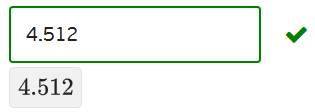

# 1. Построение базовой модели

Избавьтесь от категориальных признаков и обучите модель линейной регрессии (<code>LinearRegression()</code>) на тренировочном наборе данных. Выполните предсказания для тестового набора данных. Оцените модель при помощи метрики <code>r2_score()</code>.

In [ ]:
# Обучение модели
model = LinearRegression()
model.fit(
    X_train.drop(columns=['Species']),
    y_train
)

# Предсказание
y_pred = model.predict(X_test.drop(columns=['Species']))

# Оценка качества
r2 = r2_score(y_test, y_pred)
print(f'R\u00B2 на тестовом наборе: {r2:.3f}')

R² на тестовом наборе: 0.876


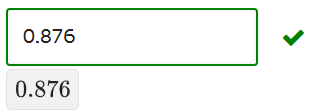

# 2. Добавление предварительной обработки признаков.

## Использование PCA

При помощи, например, <code>sns.heatmap()</code>, постройте матрицу корреляций признаков тренировочного набора данных и определите тройку наиболее коррелированных между собой признаков.

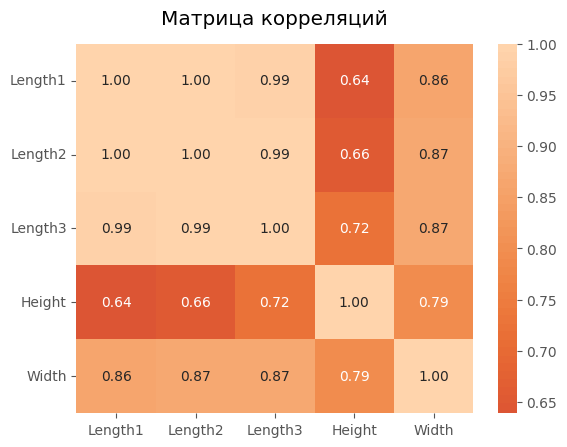

In [ ]:
sns.heatmap(
    data=X_train.drop(columns=['Species']).corr(),
    annot=True,
    fmt='.2f',
    center=0
)

plt.title('Матрица корреляций', y=1.03)
plt.yticks(rotation=0)
plt.show()

Линейные модели достаточно плохо реагируют на коррелированные признаки, поэтому от таких признаков имеет смысл избавиться еще до начала обучения.

Для уменьшения количества неинформативных измерений используйте метод главных компонент.

1) Примените метод главных компонент (<code>PCA(n_components=3, svd_solver='full')</code>) для трех найденных наиболее коррелированных признаков.

2) Вычислите долю объясненной дисперсии при использовании только первой главной компоненты.

3) Замените три наиболее коррелированных признака на новый признак <code>Lengths</code>, значения которого совпадают со значениями счетов первой главной компоненты.

In [ ]:
# Применяем PCA
lengths = ['Length1', 'Length2', 'Length3']
pca = PCA(n_components=3, svd_solver='full')
pca.fit(X_train[lengths])

# Доля объяснённой дисперсии 1ГК
explained_variance_ratio_first = pca.explained_variance_ratio_[0]
print(f"Доля объяснённой дисперсии первой главной компоненты: {explained_variance_ratio_first:.3f}")

Доля объяснённой дисперсии первой главной компоненты: 0.996


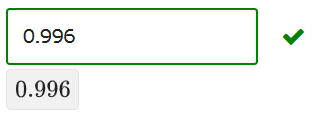

Примените полученное преобразование для тех же признаков в тестовом наборе данных. Обратите внимание, что заново обучать преобразование `PCA` не нужно. Аналогично предыдущему этапу замените три рассмотренных признака на один.

In [ ]:
lengths_train = pca.transform(X_train[lengths])
lengths_test = pca.transform(X_test[lengths])

X_train = X_train.drop(columns=lengths)
X_test = X_test.drop(columns=lengths)

X_train['Lengths'] = lengths_train[:, 0]
X_test['Lengths'] = lengths_test[:, 0]

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи <code>r2_score()</code>.

In [ ]:
# Обучение модели
model = LinearRegression()
model.fit(
    X_train.drop(columns=['Species']),
    y_train
)

# Предсказание
y_pred = model.predict(X_test.drop(columns=['Species']))

# Оценка качества
r2 = r2_score(y_test, y_pred)
print(f'R\u00B2 на тестовом наборе: {r2:.3f}')

R² на тестовом наборе: 0.864


Видно, что точность значительно не изменилась.

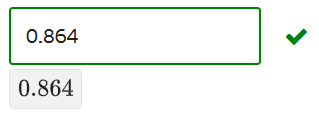

## Модификация признаков

Постройте графики зависимостей признаков от целевой переменной, например, при помощи <code>sns.pairplot()</code>.

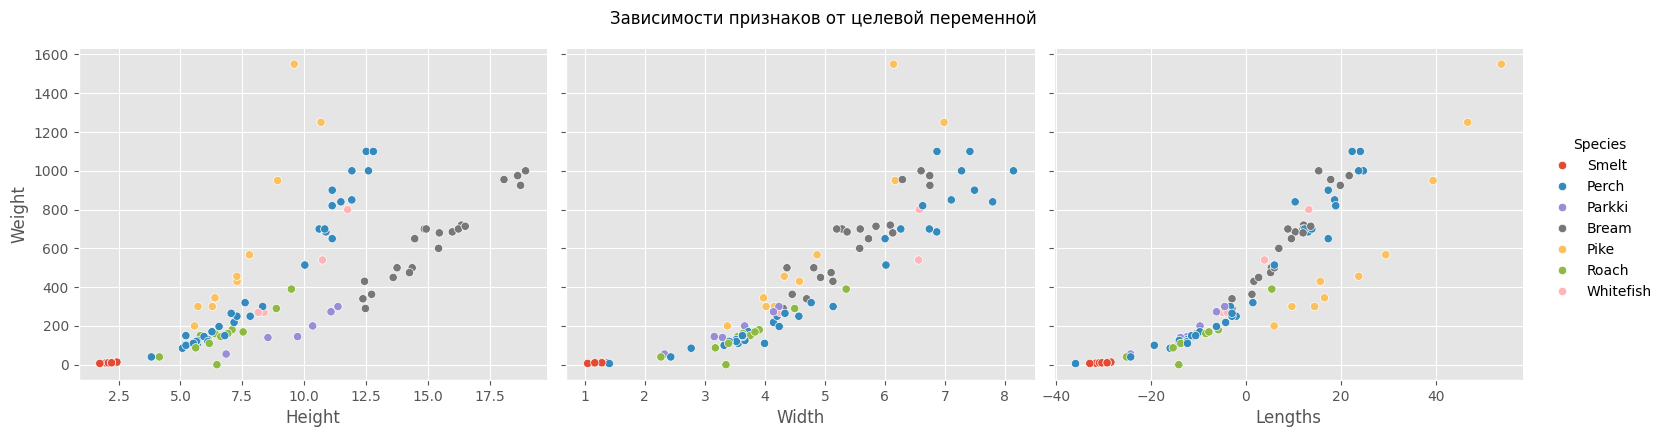

In [ ]:
size_features = ['Height', 'Width', 'Lengths']
viz_df = pd.concat([X_train, y_train], axis=1)

sns.pairplot(
    viz_df,
    y_vars=['Weight'],
    x_vars=size_features,
    hue='Species',
    height=4,
    aspect=1.3
)

plt.suptitle('Зависимости признаков от целевой переменной', y=1.07)
plt.show()

Видно, что масса, вообще говоря, нелинейно зависит от остальных параметров. Значит, чтобы линейная модель хорошо справлялась с предсказанием, признаки имеет смысл преобразовать так, чтобы зависимость стала более похожей на линейную. Но как придумать такую зависимость?

Логично предположить, что масса рыбы должна каким-то гладким образом зависеть от остальных параметров, отвечающих так или иначе за размеры. Если впомнить, что масса — это произведение плотности на объем, то

$$
m = \rho \cdot V.
$$

Допустим, что средняя плотность у всех рыб одинаковая, и вспомним, что при гомотетии объем объекта зависит от линейных размеров как куб, тогда получим

$$
m\sim V\sim d^3
$$

Все признаки тренировочного и тестового наборов данных, отвечающие так или иначе за размеры (<code>Height, Width, Lengths</code>), возведите в третью степень, и проверьте, стала ли зависимость массы от этих признаков похожа на линейную.

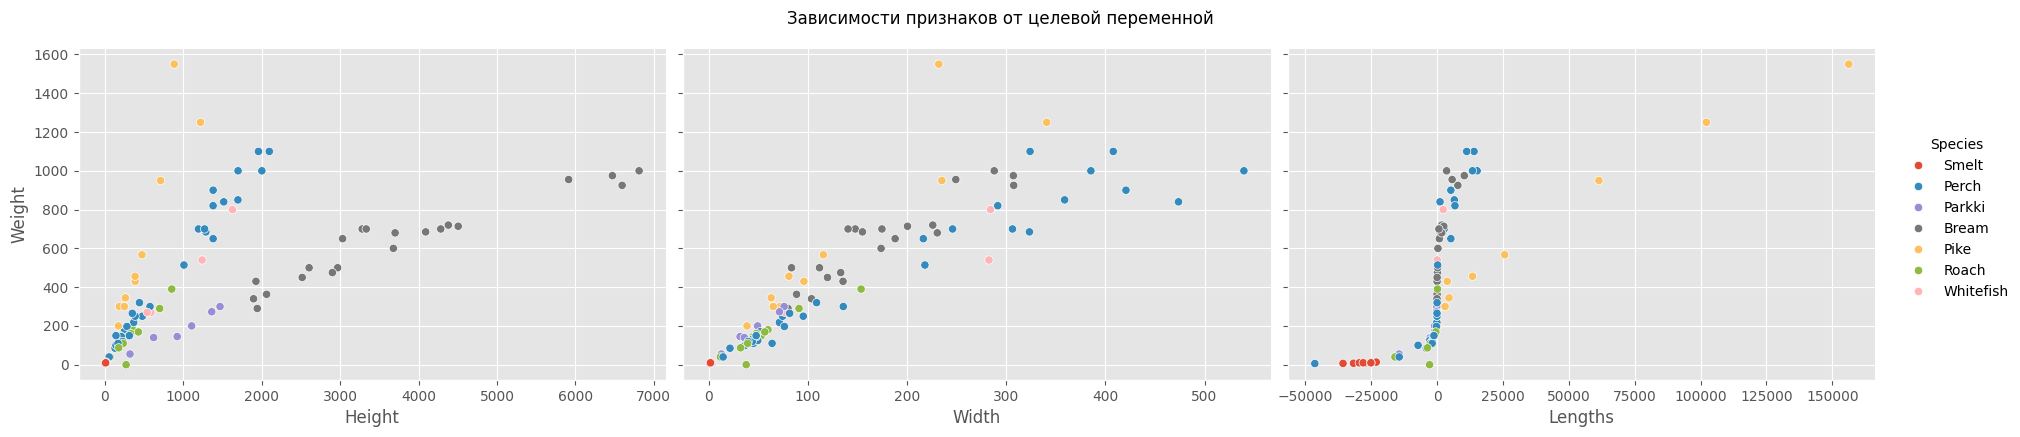

In [ ]:
viz_df = pd.concat([X_train, y_train], axis=1)
viz_df[size_features] = viz_df[size_features] ** 3

sns.pairplot(
    viz_df,
    y_vars=['Weight'],
    x_vars=size_features,
    hue='Species',
    height=4,
    aspect=1.6
)

plt.suptitle('Зависимости признаков от целевой переменной', y=1.07)
plt.show()

In [ ]:
X_train[size_features] = X_train[size_features] ** 3
X_test[size_features] = X_test[size_features] ** 3

Введите выборочное среднее колонки <code>Width</code> тренировочного набора данных после возведения в куб.

In [ ]:
X_train.Width.mean().round(3)

np.float64(130.339)

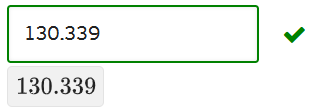

Выберите изображения, соответствующие зависимости <code>Weight</code> от <code>Width</code> до преобразования и после.

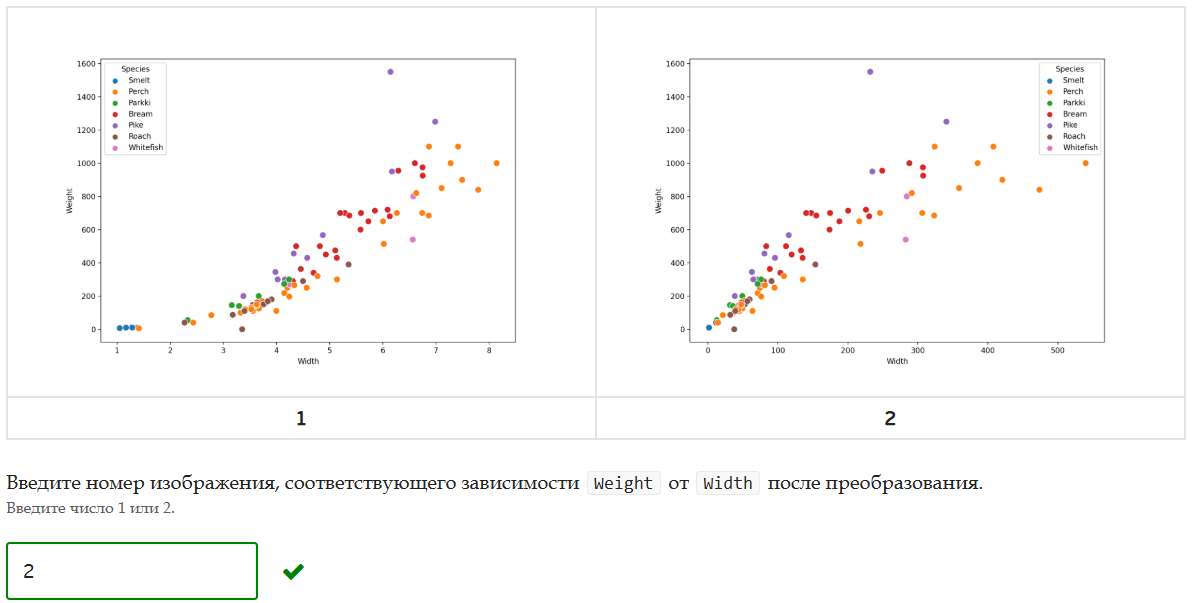

Обучите базовую модель линейной регресси на полученных тренировочных данных, снова выбросив категориальные признаки. Выполните предсказания для тестовых данных, оцените при помощи `r2_score()`.

In [ ]:
# Обучение модели
model = LinearRegression()
model.fit(
    X_train[size_features],
    y_train
)

# Предсказание
y_pred = model.predict(X_test[size_features])

# Оценка качества
r2 = r2_score(y_test, y_pred)
print(f'R\u00B2 на тестовом наборе: {r2:.3f}')

R² на тестовом наборе: 0.921


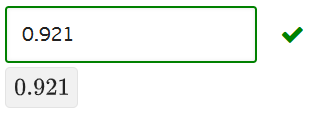

Обратите внимание на то, как такая нехитрая работа с признаками помогла разительно улучшить точность модели!

## Добавление категориальных признаков

Произведите <code>one-hot</code> кодировние категориального признака `Species`, например, с помощью <code>pd.get_dummies()</code>.

Обучите модель линейной регресси на полученных тренировочных данных. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

<b>Примечание</b>: Мы специально использовали стратифицированное разделение, чтобы все значения категориального признака <code>Species</code> присутствовали во всех наборах данных. Но такое возможно не всегда. Про то, как с этим бороться можно почитать, [например, здесь](https://predictivehacks.com/?all-tips=how-to-deal-with-get_dummies-in-train-and-test-dataset).

In [ ]:
# OHE
X_train_encoded = pd.get_dummies(X_train, columns=['Species'])
X_test_encoded = pd.get_dummies(X_test, columns=['Species'])

# Обучение модели
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Предсказание
y_pred = model.predict(X_test_encoded)

# Оценка качества
r2 = r2_score(y_test, y_pred)
print(f'R\u00B2 на тестовом наборе: {r2:.3f}')

R² на тестовом наборе: 0.939


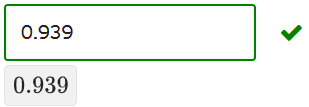

И снова точность возрасла.

Как можно увидеть, после `one-hot` кодирования признаки стали коррелированы. От этого можно избавиться, например, при помощи параметра `drop_first=True`. Заново обучите модель после исправления этого недочета. Выполните предсказания для тестовых данных, оцените модель при помощи <code>r2_score()</code>.

In [ ]:
# OHE
X_train_encoded = pd.get_dummies(X_train, columns=['Species'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['Species'], drop_first=True)

# Обучение модели
model = LinearRegression()
model.fit(X_train_encoded, y_train)

# Предсказание
y_pred = model.predict(X_test_encoded)

# Оценка качества
r2 = r2_score(y_test, y_pred)
print(f'R\u00B2 на тестовом наборе: {r2:.3f}')

R² на тестовом наборе: 0.939


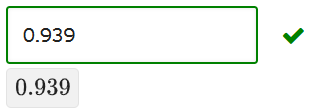

На таком сравнительно небольшом наборе данных, впрочем, разницы мы не видим.

# 3. Итоговое предсказание

Используя весь датасет как обучающий, выполните предсказания для данных `fish_reserved.csv`. В качестве метрики используется `r2_score`.

## Вариант 1

In [ ]:
# Данные
X = data.drop(columns=['Weight']).copy()
test = pd.read_csv('fish_reserved.csv')
y = data.Weight.copy()

lengths = ['Length1', 'Length2', 'Length3']
size_features = ['Height', 'Width', 'Lengths']

In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Species  40 non-null     object 
 1   Length1  40 non-null     float64
 2   Length2  40 non-null     float64
 3   Length3  40 non-null     float64
 4   Height   40 non-null     float64
 5   Width    40 non-null     float64
dtypes: float64(5), object(1)
memory usage: 2.0+ KB


In [ ]:
# PCA
pca = PCA(n_components=1, svd_solver='full')
pca.fit(X[lengths])

X['Lengths'] = pca.transform(X[lengths])
test['Lengths'] = pca.transform(test[lengths])

X = X.drop(columns=lengths)
test = test.drop(columns=lengths)

# Числовые фичи возводим в куб
X[size_features] = X[size_features] ** 3
test[size_features] = test[size_features] ** 3

# OHE
X_encoded = pd.get_dummies(X, columns=['Species'], drop_first=True)
test_encoded = pd.get_dummies(test, columns=['Species'], drop_first=True)

# Обучение модели
model = LinearRegression()
model.fit(X_encoded, y)

# Предсказание
print('Предсказание:\n')
model.predict(test_encoded)

Предсказание:



array([ 115.09542494,  167.16936251,  119.53362955,  119.9735435 ,
         85.49662161,  198.10125498,   67.21469221,  432.06103752,
        382.21135428,  126.02863666, 2105.91829436,  188.76392423,
        602.91775337, 1039.48785615,    5.13384353,  581.26275142,
        126.2033317 ,  813.30100446, 1461.82673204,  120.76127183,
        564.71154429,  193.46121624,  115.65108458,  196.23823088,
        354.49066243,  598.87357866,  371.02830916,   26.12026373,
         85.38774392,  -16.79036008,  938.68254721,  511.76523087,
        533.47816064,  172.31096385,   38.30231952,   78.6394041 ,
        165.8725462 ,  942.16843229,  751.45974073,  173.97427872])

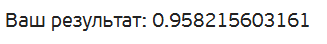

## Вариант 2

In [ ]:
# Данные
X = data.drop(columns=['Weight']).copy()
test = pd.read_csv('fish_reserved.csv')
y = data.Weight.copy()

lengths = ['Length1', 'Length2', 'Length3']
size_features = ['Height', 'Width', 'Lengths']

# PCA
pca = PCA(n_components=1, svd_solver='full')
pca.fit(X[lengths])

X_pca = X.drop(columns=lengths)
X_pca['Lengths'] = pca.transform(X[lengths])

test_pca = test.drop(columns=lengths)
test_pca['Lengths'] = pca.transform(test[lengths])

# Pipeline: полиномы + OHE + регрессия
pipeline = Pipeline([
    ('preprocess', ColumnTransformer([
        ('poly', PolynomialFeatures(degree=3, include_bias=False), size_features),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Species'])
    ])),
    ('regressor', LinearRegression())
])

pipeline.fit(X_pca, y)
print('Предсказание:\n')
pipeline.predict(test_pca)

Предсказание:



array([ 101.81345459,  105.89361737,   61.61691736,  108.17153451,
         74.08105664,  152.86465374,   37.47510879,  471.25077317,
        395.89648495,   87.01882782, 1721.37640686,  177.91164811,
        628.19924006, 1082.57221623,   38.4179679 ,  645.49403418,
        116.16416079,  777.04133014, 1536.88011573,   86.78799245,
        653.9879985 ,  177.78957374,   65.85421495,  170.89758902,
        296.08436033,  603.45692543,  357.34508635,   24.32210513,
          6.92927348,   32.76416864,  935.89686608,  460.41614959,
        580.13602212,  149.06049699,   10.40933667,   61.10481217,
        129.26002275,  938.77300017,  722.65165002,  141.94124029])

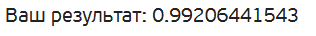